In [89]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
import statistics

%matplotlib inline
print(tf.__version__)

2.10.1


Visualizing dimensions of dateset images


Number of images: 1660
Mean: 94.04939759036145
Geometric mean: 84.72840301601072
Median: 76.0
Min: 49
Max: 514


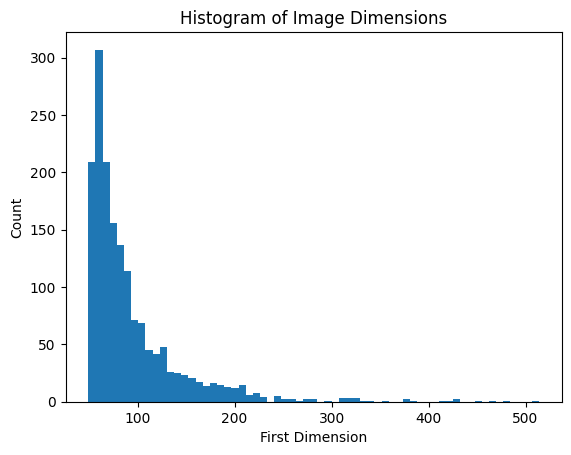

In [90]:
dataset = "../mldataset/cropped"
dirs = [os.path.join(dataset, "ConfirmedFiles"),
        os.path.join(dataset, "RejectedFiles")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        imgs = os.path.join(i, j, "images")
        if not os.path.exists(imgs):
            continue
        for img in os.listdir(imgs):

            img = os.path.join(imgs, img)

            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Mean:", np.mean(dimensions))
print("Geometric mean:", statistics.geometric_mean(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [91]:
confirmed_num = 0
for subfolder in os.listdir(dirs[0]):
    imgs = os.path.join(dirs[0], subfolder, "images")
    confirmed_num += len(os.listdir(imgs))
print("Number of confirmed images:", confirmed_num)

rejected_images = []
rejected_num = 0
for subfolder in os.listdir(dirs[1]):
    if not os.path.exists(os.path.join(dirs[1], subfolder, "images")):
        continue
    imgs = os.path.join(dirs[1], subfolder, "images")
    rejected_images += [os.path.join(imgs, filename)
                        for filename in os.listdir(imgs)]
    rejected_num += len(os.listdir(imgs))
print("Number of rejected images:", rejected_num)

Number of confirmed images: 830
Number of rejected images: 830


Class balancing using image augmentation


In [92]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

# balance classes by using data augmentation
while rejected_num < confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)

    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized", "images"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(
        dirs[1], "synthesized", "images", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", "images", base_filename +
            "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of confirmed images:", confirmed_num)
print("Number of rejected images:", rejected_num)

Classes balanced.
Number of confirmed images: 830
Number of rejected images: 830


Dataset creation


In [93]:
IMG_SIZE = int(np.median(dimensions))  # seems about right
BATCH_SIZE = 32
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
)
class_names = train_ds.class_names
# label 0 - confirmed, label 1 - rejected
AUTOTUNE = tf.data.AUTOTUNE

Found 1660 files belonging to 2 classes.
Using 1162 files for training.
Using 498 files for validation.


Dataset normalization


In [94]:
def standardize_image(image, label):
    """
        Linearly scales each image in image to have mean 0 and variance 1.
    """
    image = rescale(image)
    image = tf.image.per_image_standardization(image)
    #
    return image, label


rescale = layers.Rescaling(1.0 / 255)
# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

# buffered prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Dataset image visualization


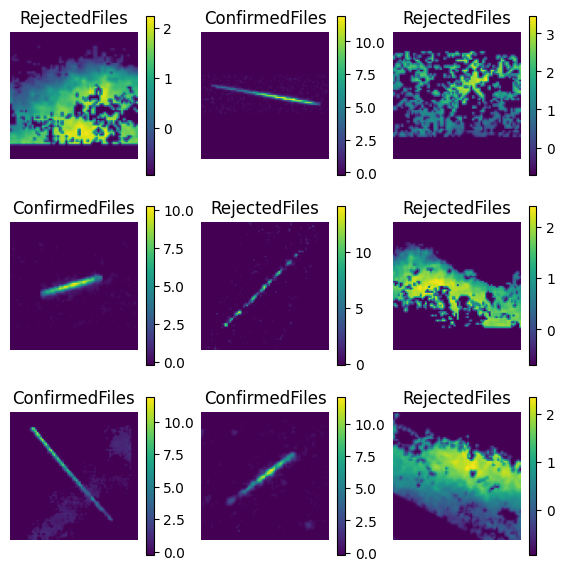

In [95]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("float32")
        # print(img.min(), img.max())

        # img = tf.image.per_image_standardization(img)
        # print(img.numpy().min(),img.numpy().max())

        plt.imshow(img)
        # print("Label:", labels[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        plt.colorbar()

Model creation

In [96]:
# model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133

model = models.Sequential()

# added by me, so that these normalization steps arent done before the model
# model.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
# model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(8, (5, 5), activation="relu"))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.build((BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (32, 72, 72, 8)           208       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 14, 14, 8)          0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (32, 1568)                0         
                                                                 
 dense_10 (Dense)            (32, 16)                  25104     
                                                                 
 dense_11 (Dense)            (32, 1)                   17        
                                                                 
Total params: 25,329
Trainable params: 25,329
Non-trainable params: 0
_________________________________________________

In [97]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (
            (precision * recall) / (precision +
                                    recall + tf.keras.backend.epsilon())
        )

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

Model compiling and training


In [98]:
model.compile(
    loss="binary_crossentropy", optimizer=optimizers.Adam(), metrics=[tf.keras.metrics.AUC(curve='PR', name='mAP'), F1Score()]
)

In [99]:
EPOCHS = 20
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/20
37/37 [==============================] - 1s 14ms/step - loss: 0.2301 - mAP: 0.9710 - f1_score: 0.9071 - val_loss: 0.1762 - val_mAP: 0.9856 - val_f1_score: 0.9533
Epoch 2/20
37/37 [==============================] - 0s 7ms/step - loss: 0.1179 - mAP: 0.9916 - f1_score: 0.9548 - val_loss: 0.1372 - val_mAP: 0.9853 - val_f1_score: 0.9531
Epoch 3/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0967 - mAP: 0.9943 - f1_score: 0.9629 - val_loss: 0.1338 - val_mAP: 0.9858 - val_f1_score: 0.9603
Epoch 4/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0806 - mAP: 0.9958 - f1_score: 0.9699 - val_loss: 0.1201 - val_mAP: 0.9875 - val_f1_score: 0.9606
Epoch 5/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0707 - mAP: 0.9969 - f1_score: 0.9701 - val_loss: 0.1208 - val_mAP: 0.9874 - val_f1_score: 0.9646
Epoch 6/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0635 - mAP: 0.9976 - f1_score: 0.9738 - val_loss: 0.1285 - val_mA

Train results analysis


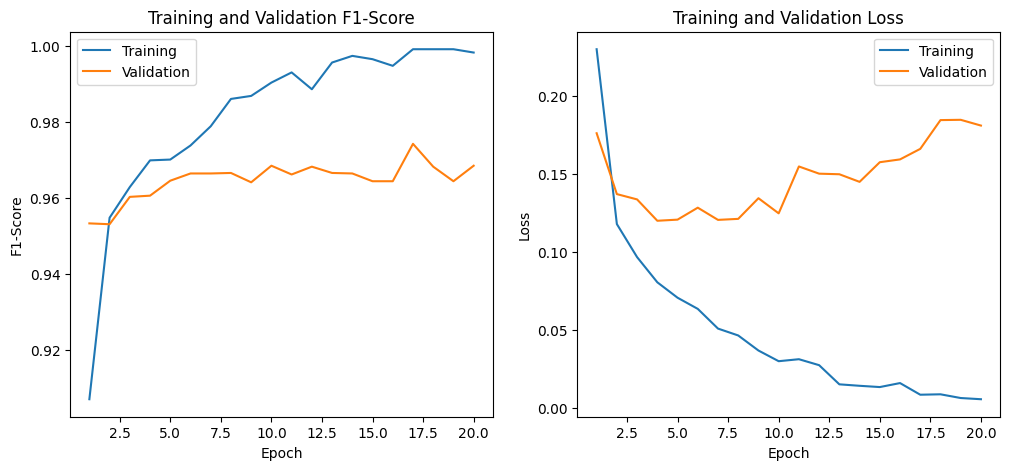

In [100]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
f1_score = history.history["f1_score"]
val_f1_score = history.history["val_f1_score"]

epoch_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, f1_score, label="Training")
plt.plot(epoch_range, val_f1_score, label="Validation")
plt.title("Training and Validation F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label="Training")
plt.plot(epoch_range, val_loss, label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Confusion matrix


In [101]:
Y_pred = model.predict(val_ds)

Y_pred_classes = np.squeeze(np.round(Y_pred))

Y_true = np.squeeze(np.concatenate([y for x, y in val_ds], axis=0))

confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes, num_classes=2)
print(confusion_mtx)

16/16 [==============================] - 0s 1ms/step
tf.Tensor(
[[236   6]
 [ 10 246]], shape=(2, 2), dtype=int32)


Predicting a single example


tf.Tensor([0.], shape=(1,), dtype=float32)


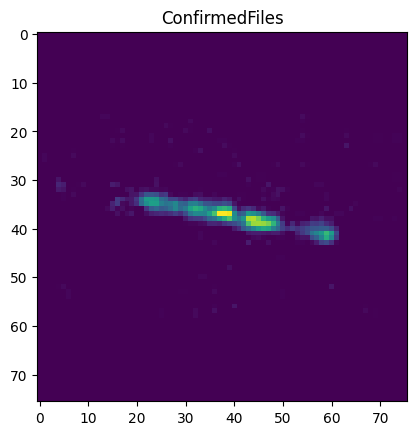

1/1 [==============================] - 0s 38ms/step
[[0.00087985]]
Prediction:           0.0008798480266705155 - > ConfirmedFiles


In [102]:
x = val_ds.shuffle(1000).take(1)
for img, lab in x:
    print(lab[0])
    plt.figure()
    plt.imshow(img[0].numpy().astype("float32"))
    plt.title(f'{class_names[int(lab[0])]}')
    plt.show()
    img = img[0][np.newaxis, ...]
    prediction = model.predict(img)
    print(prediction)
    print(f'Prediction: \
          {prediction[0][0]} - > {class_names[int(np.round(prediction[0][0]))]}')
    break

Testing Fiachra's model


In [103]:
interpreter = tf.lite.Interpreter(model_path="meteorml32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on input data.
input_shape = input_details[0]["shape"]
correct_predictions = 0
total_predictions = 0

resize_32 = layers.Resizing(32, 32)
rescale = layers.Rescaling(1.0 / 255)
# Iterate over each batch
sample = val_ds.shuffle(1000).take(10)
for image_batch, label_batch in sample:
    total_predictions += image_batch.shape[0]
    # plt.figure()
    # img=resize_32(image_batch[0])
    # img=rescale(img)
    # img=image_batch[0]
    # print(img.numpy().max())
    # plt.imshow(img.numpy().astype("uint8"))
    # plt.title(f'{class_names[int(label_batch[0])]}')
    # plt.show()
    for i in range(image_batch.shape[0]):
        img = resize_32(image_batch[i])
        # img=rescale(img)

        """         
        plt.figure()
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(f'{class_names[int(label_batch[i])]}')
        plt.show() """
        input_data = np.expand_dims(img, axis=0)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])
        # print(output_data)
        prediction = np.argmax(output_data)  # Get the highest scoring class

        # i use != because this model has reversed labels
        correct_predictions += prediction != label_batch[i].numpy()
        # break
    # break

print("Correct predictions:", correct_predictions)
# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Test accuracy:", accuracy)

Correct predictions: [169]
Test accuracy: [0.528125]
